In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer

import matplotlib.pyplot as plt
import arviz as az
import corner

In [3]:
import antiglitch
from antiglitch import freqs, extract_glitch, fsignal, to_fd, glitch_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
if False:
    numpyro.set_host_device_count(4) # Use 4 cores if available

In [5]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(glitch_model),
    num_warmup=2000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

In [7]:
ifo, key, num = ('L1', 'koi', 0)
snip = antiglitch.Snippet(ifo, key, num)

invasd = snip.invasd
fglitch = to_fd(snip.whts)

In [8]:
%time sampler.run(jax.random.PRNGKey(0), freqs[1:], invasd[1:], data=fglitch[1:])

sample: 100%|██████████| 3000/3000 [00:28<00:00, 103.87it/s, 263 steps of size 6.54e-03. acc. prob=0.93]


CPU times: user 32.6 s, sys: 135 ms, total: 32.7 s
Wall time: 32.6 s


In [9]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')

In [10]:
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

In [11]:
inf

{'amp_r': 217.28684997558594,
 'amp_i': -42.58863830566406,
 'f0': 116.3301773071289,
 'gbw': 0.7338756322860718,
 'time': -0.7822431325912476,
 'amp': 221.42124397862884,
 'phase': -0.19354830656385427}

In [14]:
glitch1 = fsignal(freqs, 14., 0.78)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

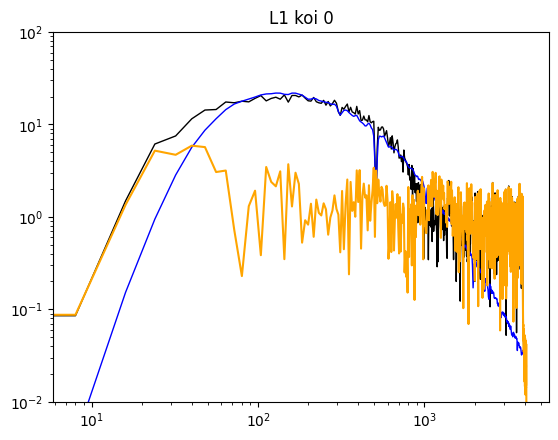

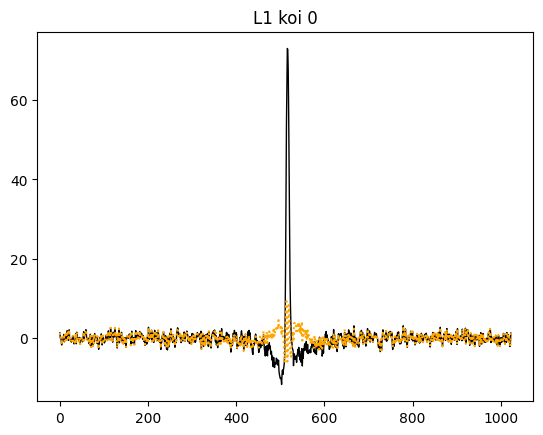

In [15]:
snip.set_infer(inf)
snip.plot()

In [50]:
print(az.summary(itrace, kind='stats'))

          mean      sd   hdi_3%  hdi_97%
amp_i   -3.993   2.115   -7.335   -0.034
amp_r   -2.988   2.683   -7.220    2.266
f0     375.295  24.142  337.206  399.970
gbw      0.545   0.173    0.335    0.823
time    -0.654   0.001   -0.656   -0.651


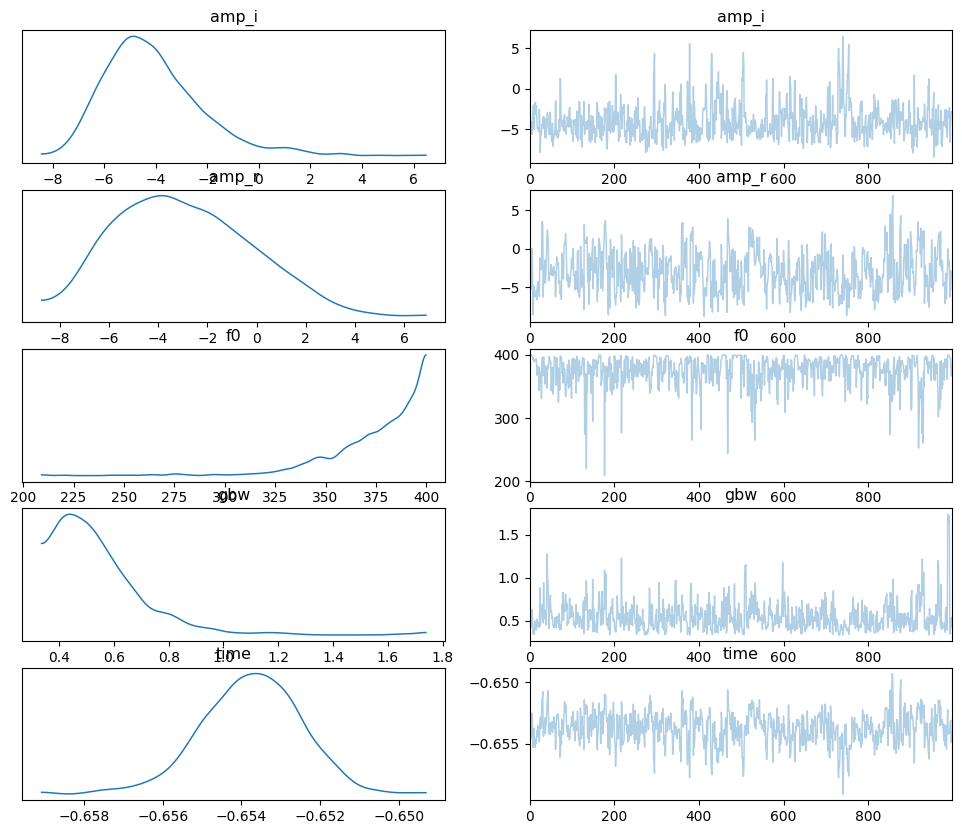

In [51]:
az.plot_trace(itrace);

In [13]:
# An attempt at finding the MAP

num_svi_steps = 2000
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(glitch_model)
svi = SVI(glitch_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 2000/2000 [00:01<00:00, 1047.41it/s, init loss: 4112.2671, avg. loss [1901-2000]: 1895.7081]


In [4]:
jax.__file__

'/home/andrew.lundgren/.conda/envs/jax/lib/python3.9/site-packages/jax/__init__.py'